In [1]:
import cobra
from cobra import Model, Reaction, Metabolite
import pandas as pd
import cplex
import optlang
import math
import json
import sys
import cProfile
from optlang.symbolics import Zero, add
import cobra.util.solver as sutil
from cobra.flux_analysis.parsimonious import pfba
from IPython.core.display import HTML

import os
os.environ["HOME"] = 'C:\\Users\\Andrew Freiburger\\Dropbox\\My PC (DESKTOP-M302P50)\\Documents\\UVic Civil Engineering\\Internships\\Agronne\\cobrakbase'
import cobrakbase
token = 'I6WL7MAW5Z4QO3OQ62YUR6HJM6RAUFHE'
kbase = cobrakbase.KBaseAPI(token)
sys.path.append("/Users/chandhanavoleti/Dropbox/My PC (DESKTOP-M302P50)/Documents/UVic Civil Engineering/Internships/Agronne/ModelSEEDpy/ModelSEEDpy")
#import modelseedpy.fbapkg
from modelseedpy import ElementUptakePkg, SimpleThermoPkg, ReactionUsePkg, BilevelPkg, CommKineticPkg, KBaseMediaPkg

from collections import Counter
import numpy as np
from itertools import combinations
import networkx as nx


cobrakbase 0.2.8


In [12]:
def communityFBA(modelInfo,mediaInfo,kinetic_coeff,abundances=None):
    # import the model and media
    model = kbase.get_from_ws(modelInfo[0],modelInfo[1])
    media = kbase.get_from_ws(mediaInfo[0],mediaInfo[1])
    kmp = KBaseMediaPkg(model)
    kmp.build_package(media)
    model.solver = 'optlang-cplex'
    
    # applying uptake limit to total carbon uptake by model
    '''eup = ElementUptakePkg(model)
    eup.build_package({"C":60})
    '''
    
    # applying community model kinetic constraints
    '''ckp = CommKineticPkg(model)
    ckp.build_package(kinetic_coeff,abundances)
    '''

    biomass_objective = model.problem.Objective(
        1 * model.reactions.bio1.flux_expression,
        direction='max')
    model.objective = biomass_objective

    # FBA
    sol=model.optimize()
    
    # pFBA
#     sol = cobra.flux_analysis.pfba(model)
    
    #print(model.summary())

    # calculate the metabolic exchanges
    metabolite_uptake = {}
    compartment_numbers = []
    for rxn in model.reactions:
        if rxn.id[-2] == ('c' or 'p'):
            if rxn.id[-1] != '0' and rxn.id[-1] != 0:
                compartment_number = rxn.id[-1]
                '''print(compartment_number, '\t', rxn.id)'''
                if not re.search('[a-z]',compartment_number, re.IGNORECASE):
                    compartment_numbers.append(compartment_number)
                '''else:
                    print('--->', compartment_number, '\t', rxn.id)'''


                for metabolite in rxn.metabolites:
                    if metabolite.compartment == "e0":
                        rate_law = 0
                        flux = solution.fluxes[rxn.id]
                        if flux != 0:
                            rate_law += rxn.metabolites[metabolite]*flux
                            metabolite_uptake[(metabolite.id,compartment_number)] = rate_law

    compartment_numbers = unique(compartment_numbers)
    number_of_compartments = len(compartment_numbers)

    # Cross feeding
    external_metabolites = []
    for rxn in model.reactions:
        for metabolite in rxn.metabolites:
            if metabolite.compartment == "e0":
                external_metabolites.append(metabolite.id)

    cross_all = []
    for metabolite in external_metabolites:
        r_out = {x: r for (m, x), r in metabolite_uptake.items() if m == metabolite and r > 0}
        r_in = {x: -r for (m, x), r in metabolite_uptake.items() if m == metabolite and -r > 0}
        total_in = sum(r_in.values())
        total_out = sum(r_out.values())
        total = max(total_in, total_out)
        if total_in > total_out:
            r_out[None] = total_in - total_out
        if total_out > total_in:
            r_in[None] = total_out - total_in

        cross = [(o1, o2, metabolite, r1 * r2 / total) for o1, r1 in r_out.items() for o2, r2 in r_in.items()]
        cross_all.extend(cross) # [donor, receiver, compound, rate]

    production = [[0] * numOfSpecies for i in range(numOfSpecies)] #production[donorSpecies][receiverSpecies]
    consumption = [[0] * numOfSpecies for i in range(numOfSpecies)]

    for i in cross_all:
        if i[0] is not None and i[1] is not None:
            production[int(i[0])-1][int(i[1])-1] += i[3]
            consumption[int(i[1])-1][int(i[0])-1] += i[3]
    
    graph=nx.Graph()
    for i in speciesNum:
        graph.add_node(i)
    for k in combinations(speciesNum, 2):
        sp1 = int(k[0])-1
        sp2 = int(k[1])-1
        if production[sp1][sp2] > consumption[sp2][sp1]:
            interaction_flux = production[sp1][sp2]
        else:
            interaction_flux = consumption[sp2][sp1]
        graph.add_edge(k[0],k[1],weight=interaction_flux)

    pos=nx.circular_layout(graph)
    nx.draw_networkx(graph,pos)
    labels = nx.get_edge_attributes(graph,'weight')
    nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)

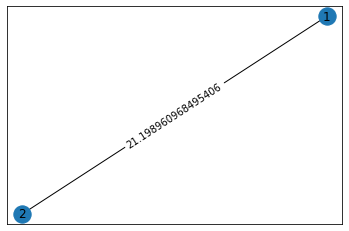

In [13]:
modelInfo_2 = ["CMM_iAH991V2_iML1515.kb",40576]
mediaInfo_2 = ["Btheta_Ecoli_minimal_media",40576]
communityFBA(modelInfo_2,mediaInfo_2,2100,{"1":0.5,"2":0.5})

In [ ]:
# changing the kinetic coefficient
communityFBA(modelInfo_2,mediaInfo_2,2300,{"1":0.5,"2":0.5})

In [ ]:
# changing the species abundances
communityFBA(modelInfo_2,mediaInfo_2,2100,{"1":0.1,"2":0.9})

In [ ]:
modelInfo_3 = ["electro.community.edited.v2",93204]
mediaInfo_3 = ["CO2_minimal",93204]
communityFBA(modelInfo_3,mediaInfo_3,2100)

In [ ]:
# changing the kinetic coefficient
communityFBA(modelInfo_3,mediaInfo_3,2300)

In [ ]:
# changing the species abundances
communityFBA(modelInfo_3,mediaInfo_3,2100,abundances={"1":0.1,"2":0.1,"3":0.8})

In [ ]:
# modelInfo_7 = ["Hot_Lake_seven.mdl.v2",94153]
# mediaInfo_7 = ["HotLakeMedia",94153]
# communityFBA(modelInfo_7,mediaInfo_7,2100)